# Persistent homology for smartphone data analysis (pedestrian recognition)

In [1]:
import numpy as np
import pandas as pd
import pickle as pickle
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline

> ## <span style="color:blue">Question 1</span>: Loading Data

In [6]:
path = "/Users/cloti/Desktop/MSc in Data Science/T1 2017/Geometric Methods/Final Project/PersistentHomology/data_acc_rot.dat"
#path="/Users/yaguethiam/PersistentHomology/data_acc_rot.dat"
#path = '/Users/Melisande/Gudhi/2017-10-02-10-19-30_GUDHI_2.0.1.tar/Gudhi/PersistentHomology/data_acc_rot.dat'

In [7]:
f = open(path,"rb")
data = pickle.load(f,encoding='latin1')
f.close()

data_A = data[0]
data_B = data[1] 
data_C = data[2]
label = data[3]

### plot a sample of acceleration data

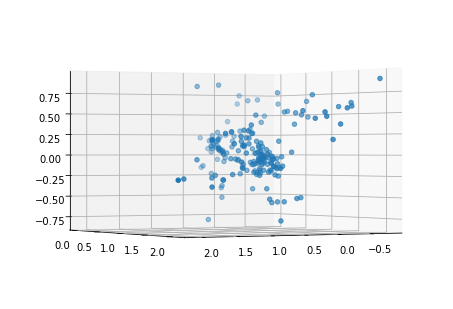

In [12]:
from mpl_toolkits.mplot3d import Axes3D
data_A_sample = data_A[0]
plt.subplots_adjust(bottom = 0.1)
fig = plt.figure()
ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=60,elev = 0)
ax.scatter(
    data_A_sample[:, 0], data_A_sample[:, 1],data_A_sample[:, 2], marker = 'o'
    )
plt.show()

> # <span style="color:blue">Question 2</span>:

__Compute and save the 0-dimensional and 1-dimensional persistence diagrams of the Rips filtrations and the alpha-shape filtrations built on top of each of the 300 point clouds in R3.__

In [13]:
import gudhi

### Average pairwise distance between two points for the 3 pedestrians

In [14]:
from scipy.spatial.distance import squareform, pdist

In [15]:
def computeMaxPairWiseDistance(points):
    matdist=squareform(pdist(points, 'euclidean'))
    sumD=[]
    for i in range(points.shape[0]):
        for j in range(i+1,points.shape[0]):
            sumD.append(matdist[i,j])
            
    npsumD=np.array(sumD)
    
    return (max(npsumD),min(npsumD),np.median(npsumD),np.mean(npsumD),np.std(npsumD))

In [16]:
def get_pedestrian_stats(pedes_id):  
    pedes_stats=np.zeros((100,5))
    if pedes_id=="A":
        data = data_A
    elif pedes_id=="B":
        data = data_B
    elif pedes_id=="C":
        data = data_C
    else:
        print("Invalid pedestrian ID, choose A, B or C")
        return(0)
    for i in range(100):
        stats=computeMaxPairWiseDistance(data[i])
        pedes_stats[i,0]=stats[0]
        pedes_stats[i,1]=stats[1]
        pedes_stats[i,2]=stats[2]
        pedes_stats[i,3]=stats[3]
        pedes_stats[i,4]=stats[4]
    pedestrian_stats=pd.DataFrame(pedes_stats,columns=['max_pairwise_distance','min_pairwise_distance',\
                                                           'median_pairwise_distance','mean_pairwise_distance','std_pairwise_distance'])
    return(pedes_stats, pedestrian_stats)


In [17]:
pedes_A_stats, pedestrian_A_stats = get_pedestrian_stats("A")
pedes_B_stats, pedestrian_B_stats = get_pedestrian_stats("B")
pedes_C_stats, pedestrian_C_stats = get_pedestrian_stats("C")

In [18]:
print("max A",np.amax(pedes_A_stats[:,0]))
print("min A", np.amin(pedes_A_stats[:,1]))
print("max B",np.amax(pedes_B_stats[:,0]))
print("min B", np.amin(pedes_B_stats[:,1]))
print("max C",np.amax(pedes_C_stats[:,0]))
print("min C", np.amin(pedes_C_stats[:,1]))

max A 3.11899657386
min A 0.00314598553716
max B 4.11443915342
min B 0.000962233859309
max C 4.57581637311
min C 0.00407823552532


In [19]:
pedestrian_A_stats

,max_pairwise_distance,min_pairwise_distance,median_pairwise_distance,mean_pairwise_distance,std_pairwise_distance
0,3.074729,0.015547,0.743386,0.794757,0.440863
1,2.899356,0.014363,0.677060,0.744717,0.434100
2,3.074729,0.015547,0.739156,0.791242,0.443478
3,2.584385,0.010270,0.694232,0.742513,0.400281
4,2.678923,0.009176,0.676241,0.730662,0.401748
5,2.717759,0.008491,0.644967,0.712770,0.414837
6,2.654506,0.015739,0.729615,0.771732,0.418423
7,3.118997,0.012076,0.704566,0.758827,0.420437
8,2.810768,0.010751,0.697458,0.740675,0.408821
9,2.708880,0.017089,0.745436,0.782410,0.424371


In [20]:
pedestrian_A_max_Dist=max(pedestrian_A_stats['max_pairwise_distance'])-np.mean(pedestrian_A_stats['std_pairwise_distance'])
pedestrian_B_max_Dist=max(pedestrian_B_stats['max_pairwise_distance'])-np.mean(pedestrian_B_stats['std_pairwise_distance'])
pedestrian_C_max_Dist=max(pedestrian_C_stats['max_pairwise_distance'])-np.mean(pedestrian_C_stats['std_pairwise_distance'])


### Selection of the max edge length for Rips complex filtration

In [21]:
maxEdgeLen=max(pedestrian_A_max_Dist,pedestrian_B_max_Dist,pedestrian_C_max_Dist)
print(maxEdgeLen)

3.95065902053


## Attempt for outliers removal 

Since the persistence diagram construction are very sensitive to outliers, we will process the initial dataset by removing potential outliers. We call outliers points that have a small number of neighboor in the dataset.

In [22]:
from sklearn.neighbors import BallTree

In [23]:
def removeOutliers(data,median_pairwise_distance):
    data_processed=[]
    for i in range(len(data)):
        max_dist=median_pairwise_distance[i]
        tree = BallTree(data[i], leaf_size=2)
        num_neigh=np.zeros(data[i].shape[0])
        for j in range(data[i].shape[0]):
            dist, ind = tree.query([data[i][j]], k=int(data[i].shape[0]/2))
            num_neigh[j]=sum((dist[0] < max_dist))
        median_neigh=np.median(num_neigh)
        std_neigh=np.std(num_neigh)
        filtered_index=(num_neigh>= median_neigh)
        process=data[i][filtered_index,:]
        #print(process.shape)
        data_processed.append(process)
    return data_processed

    

In [24]:
data_A_wo_outliers=removeOutliers(data_A,list(pedestrian_A_stats['median_pairwise_distance']))
data_B_wo_outliers=removeOutliers(data_B,list(pedestrian_B_stats['median_pairwise_distance']))
data_C_wo_outliers=removeOutliers(data_C,list(pedestrian_C_stats['median_pairwise_distance']))

## With Rips Filtration

### 0-dimensional persistence diagrams of the Rips filtrations

In order to draw the 0-dimensional persistence diagram of the Rips filtrations, we use \verb gudhi.RipsComplex on the 3D point cloud. 

In [64]:
def build_0_persistent_diag(dataset, maxEdgeLen=0.2):
    persist=[]
    for i in range(len(dataset)):
        rips = gudhi.RipsComplex(points=dataset[i],max_edge_length=maxEdgeLen)
        simplex_tree = rips.create_simplex_tree(max_dimension=1)
        diag = simplex_tree.persistence()
        persist.append(diag)
    return persist

> Compute the 0 persistent diagram for the 3 pedestrians 

In [65]:
diagA_0=build_0_persistent_diag(data_A,maxEdgeLen)
diagB_0=build_0_persistent_diag(data_B,maxEdgeLen)
diagC_0=build_0_persistent_diag(data_C,maxEdgeLen)

<module 'matplotlib.pyplot' from 'C:\\Users\\cloti\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

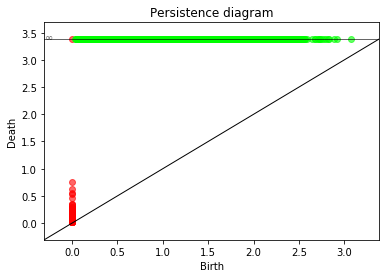

In [66]:
gudhi.plot_persistence_diagram(diagA_0[0])

### 1-dimensional persistence diagrams of the Rips filtrations

In [67]:
def build_1_persistent_diag(dataset, maxEdgeLen=0.2):
    persist=[]
    for i in range(len(dataset)):
        rips = gudhi.RipsComplex(points=dataset[i],max_edge_length=maxEdgeLen)
        simplex_tree = rips.create_simplex_tree(max_dimension=2)
        diag = simplex_tree.persistence()
        persist.append(diag)
    return persist

> Compute the 1 persistent diagram for the 3 pedestrians 

In [68]:
diagA_1=build_1_persistent_diag(data_A,maxEdgeLen)
diagB_1=build_1_persistent_diag(data_B,maxEdgeLen)
diagC_1=build_1_persistent_diag(data_C,maxEdgeLen)

<module 'matplotlib.pyplot' from 'C:\\Users\\cloti\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

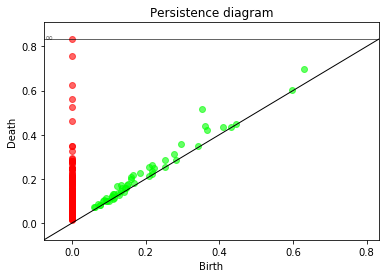

In [69]:
gudhi.plot_persistence_diagram(diagA_1[0])

diagA_1_outliers=build_1_persistent_diag(data_A_wo_outliers)
diagB_1_outliers=build_1_persistent_diag(data_B_wo_outliers)
diagC_1_outliers=build_1_persistent_diag(data_B_wo_outliers)

## With Alpha complex

In [31]:
def build_alphaComplex_diag(dataset,maxAlphaSquare=2.7**2):
    persist=[]
    for i in range(len(dataset)):
        alpha_complex = gudhi.AlphaComplex(points=dataset[i])
        simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=maxAlphaSquare)
        diag = simplex_tree.persistence()
        persist.append(diag)
    return persist

> Alpha complex based diagram

In [32]:
diagA_alpha=build_alphaComplex_diag(data_A)
diagB_alpha=build_alphaComplex_diag(data_B)
diagC_alpha=build_alphaComplex_diag(data_C)

<module 'matplotlib.pyplot' from 'C:\\Users\\cloti\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

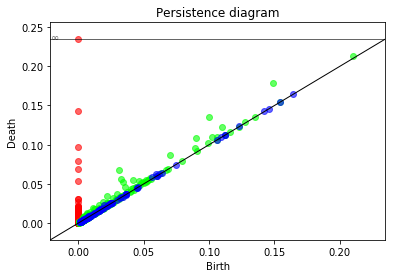

In [33]:
gudhi.plot_persistence_diagram(diagA_alpha[0])

> # <span style="color:blue">Question 3</span>: Matrices of pairwise bottleneck distances between diagrams


__Matrices of pairwise bottleneck distances between diagrams and use a dimensionality reduction algorithm to visualize them in 2D and 3D (e.g. Multidimensional Scaling).__



### Pair of (birth , death) tuple

In [34]:
def buildCleanPair(diagram):
    return [item[1] for item in diagram if not np.isinf(item[1][1])] 

> ## with 0-persitent diagram

In [35]:
diagA_0_pairs=[buildCleanPair(diag) for diag in diagA_0] 
diagB_0_pairs=[buildCleanPair(diag) for diag in diagB_0] 
diagC_0_pairs=[buildCleanPair(diag) for diag in diagC_0] 

### Pedestrian A

In [36]:
minimum_birth_A_0 = []

for i in range(len(diagA_0_pairs)):
    temp_list = []
    for j in range(len(diagA_0_pairs[i])):
        temp_list.append(diagA_0_pairs[i][j][0])
    minimum_birth_A_0.append(min(temp_list))
min_b_A_0 = min(minimum_birth_A_0)

maximum_death_A_0 = []

for i in range(len(diagA_0_pairs)):
    temp_list = []
    temp_clean = []
    for j in range(len(diagA_0_pairs[i])):
        temp_list.append(diagA_0_pairs[i][j][1])
        if np.isinf(temp_list[j]) == False:
            temp_clean.append(temp_list[j])
    maximum_death_A_0.append(max(temp_clean))
max_d_A_0 = max(maximum_death_A_0)

### Pedestrian B

In [37]:
minimum_birth_B_0 = []

for i in range(len(diagB_0_pairs)):
    temp_list = []
    for j in range(len(diagB_0_pairs[i])):
        temp_list.append(diagB_0_pairs[i][j][0])
    minimum_birth_B_0.append(min(temp_list))
min_b_B_0 = min(minimum_birth_B_0)

maximum_death_B_0 = []

for i in range(len(diagB_0_pairs)):
    temp_list = []
    temp_clean = []
    for j in range(len(diagB_0_pairs[i])):
        temp_list.append(diagB_0_pairs[i][j][1])
        if np.isinf(temp_list[j]) == False:
            temp_clean.append(temp_list[j])
    maximum_death_B_0.append(max(temp_clean))
max_d_B_0 = max(maximum_death_B_0)

### Pedestrian C

In [38]:
minimum_birth_C_0 = []

for i in range(len(diagC_0_pairs)):
    temp_list = []
    for j in range(len(diagC_0_pairs[i])):
        temp_list.append(diagC_0_pairs[i][j][0])
    minimum_birth_C_0.append(min(temp_list))
min_b_C_0 = min(minimum_birth_B_0)

maximum_death_C_0 = []

for i in range(len(diagC_0_pairs)):
    temp_list = []
    temp_clean = []
    for j in range(len(diagC_0_pairs[i])):
        temp_list.append(diagC_0_pairs[i][j][1])
        if np.isinf(temp_list[j]) == False:
            temp_clean.append(temp_list[j])
    maximum_death_C_0.append(max(temp_clean))
max_d_C_0 = max(maximum_death_C_0)

> ## with 1-persitent diagram

In [39]:
diagA_1_pairs=[buildCleanPair(diag) for diag in diagA_1] 
diagB_1_pairs=[buildCleanPair(diag) for diag in diagB_1] 
diagC_1_pairs=[buildCleanPair(diag) for diag in diagC_1]

diagA_1_outliers_pairs=[buildPair(diag) for diag in diagA_1_outliers] 
diagB_1_outliers_pairs=[buildPair(diag) for diag in diagB_1_outliers] 
diagC_1_outliers_pairs=[buildPair(diag) for diag in diagC_1_outliers]


### Pedestrian A

In [40]:
minimum_birth_A_1 = []

for i in range(len(diagA_1_pairs)):
    temp_list = []
    for j in range(len(diagA_1_pairs[i])):
        temp_list.append(diagA_1_pairs[i][j][0])
    minimum_birth_A_1.append(min(temp_list))
min_b_A_1 = min(minimum_birth_A_1)

maximum_death_A_1 = []

for i in range(len(diagA_1_pairs)):
    temp_list = []
    temp_clean = []
    for j in range(len(diagA_1_pairs[i])):
        temp_list.append(diagA_1_pairs[i][j][1])
        if np.isinf(temp_list[j]) == False:
            temp_clean.append(temp_list[j])
    maximum_death_A_1.append(max(temp_clean))
max_d_A_1 = max(maximum_death_A_1)

### Pedestrian B

In [41]:
minimum_birth_B_1 = []

for i in range(len(diagB_1_pairs)):
    temp_list = []
    for j in range(len(diagB_1_pairs[i])):
        temp_list.append(diagB_1_pairs[i][j][0])
    minimum_birth_B_1.append(min(temp_list))
min_b_B_1 = min(minimum_birth_B_1)

maximum_death_B_1 = []

for i in range(len(diagB_1_pairs)):
    temp_list = []
    temp_clean = []
    for j in range(len(diagB_1_pairs[i])):
        temp_list.append(diagB_1_pairs[i][j][1])
        if np.isinf(temp_list[j]) == False:
            temp_clean.append(temp_list[j])
    maximum_death_B_1.append(max(temp_clean))
max_d_B_1 = max(maximum_death_B_1)

### Pedestrian C

In [42]:
minimum_birth_C_1 = []

for i in range(len(diagC_1_pairs)):
    temp_list = []
    for j in range(len(diagC_1_pairs[i])):
        temp_list.append(diagC_1_pairs[i][j][0])
    minimum_birth_C_1.append(min(temp_list))
min_b_C_1 = min(minimum_birth_C_1)

maximum_death_C_1 = []

for i in range(len(diagC_1_pairs)):
    temp_list = []
    temp_clean = []
    for j in range(len(diagC_1_pairs[i])):
        temp_list.append(diagC_1_pairs[i][j][1])
        if np.isinf(temp_list[j]) == False:
            temp_clean.append(temp_list[j])
    maximum_death_C_1.append(max(temp_clean))
max_d_C_1 = max(maximum_death_C_1)

> ## with alpha complex based diagram

In [43]:
diagA_alpha_pairs=[buildCleanPair(diag) for diag in diagA_alpha] 
diagB_alpha_pairs=[buildCleanPair(diag) for diag in diagB_alpha] 
diagC_alpha_pairs=[buildCleanPair(diag) for diag in diagC_alpha]

## The function below compute the bootleneck distance between two persistent diagrams

In [44]:
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D

In [45]:
def computeMatrixBottleneckDistance(diagList1):
    matrix=np.zeros((len(diagList1),len(diagList1)))
    for i in range(len(diagList1)):
        for j in range(i,len(diagList1)):
            dist=gudhi.bottleneck_distance(diagList1[i], diagList1[j], 0.0001)
            matrix[i,j]=dist
            matrix[j,i]=dist
    return matrix

> ## With 0-persistent homology

In [46]:
matrix_bottleneck_distance_All_0=computeMatrixBottleneckDistance(diagA_0_pairs+diagB_0_pairs+diagC_0_pairs)

### (2D) plot Pedestrian A,B and C  

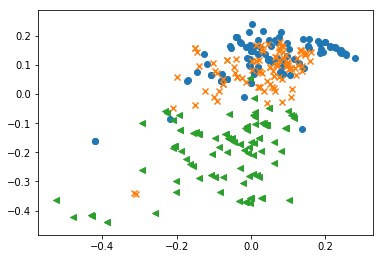

In [60]:
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos2d= mds2.fit(matrix_bottleneck_distance_All_0).embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    pos2d[:100, 0], pos2d[:100, 1], marker = 'o'
    )
plt.scatter(
    pos2d[100:200, 0], pos2d[100:200, 1], marker = 'x'
    )
plt.scatter(
    pos2d[200:300, 0], pos2d[200:300, 1], marker = '<'
    )
plt.show()


### (3D) plot Pedestrian A,B and C

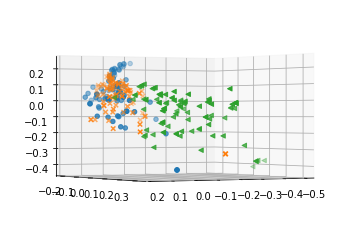

In [61]:
mds3 = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos3d= mds3.fit(matrix_bottleneck_distance_All_0).embedding_


plt.subplots_adjust(bottom = 0.1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=60,elev = 0)
ax.scatter(
    pos3d[:100, 0], pos3d[:100, 1],pos3d[:100, 2], marker = 'o'
    )
ax.scatter(
    pos3d[100:200, 0], pos3d[100:200, 1],pos3d[100:200, 2], marker = 'x'
    )
ax.scatter(
    pos3d[200:300, 0], pos3d[200:300, 1],pos3d[200:300, 2], marker = '<'
    )
plt.show()



> ## With 1-persistent homology

In [62]:
matrix_bottleneck_distance_All_1=computeMatrixBottleneckDistance(diagA_1_pairs+diagB_1_pairs+diagC_1_pairs)

### (2D) plot Pedestrian A,B and C

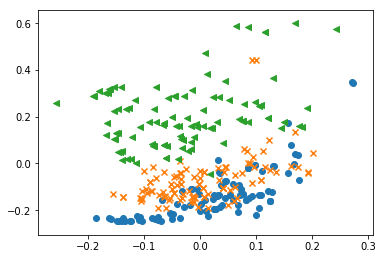

In [63]:
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos2d= mds2.fit(matrix_bottleneck_distance_All_1).embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    pos2d[:100, 0], pos2d[:100, 1], marker = 'o'
    )
plt.scatter(
    pos2d[100:200, 0], pos2d[100:200, 1], marker = 'x'
    )
plt.scatter(
    pos2d[200:300, 0], pos2d[200:300, 1], marker = '<'
    )
plt.show()



### (3D) plot Pedestrian A,B and C

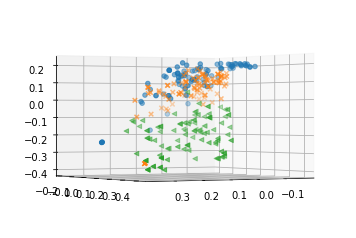

In [82]:
mds3 = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos3d= mds3.fit(matrix_bottleneck_distance_All_1).embedding_


plt.subplots_adjust(bottom = 0.1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=60,elev = 0)
ax.scatter(
    pos3d[:100, 0], pos3d[:100, 1],pos3d[:100, 2], marker = 'o'
    )
ax.scatter(
    pos3d[100:200, 0], pos3d[100:200, 1],pos3d[100:200, 2], marker = 'x'
    )
ax.scatter(
    pos3d[200:300, 0], pos3d[200:300, 1],pos3d[200:300, 2], marker = '<'
    )
plt.show()

> ## With alpha complex

In [86]:
matrix_bottleneck_distance_All_alpha=computeMatrixBottleneckDistance(diagA_alpha_pairs+diagB_alpha_pairs+diagC_alpha_pairs)

### (2D) plot Pedestrian A,B and C

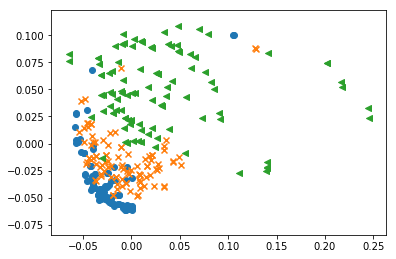

In [90]:
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos2d= mds2.fit(matrix_bottleneck_distance_All_alpha).embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    pos2d[:100, 0], pos2d[:100, 1], marker = 'o'
    )
plt.scatter(
    pos2d[100:200, 0], pos2d[100:200, 1], marker = 'x'
    )
plt.scatter(
    pos2d[200:300, 0], pos2d[200:300, 1], marker = '<'
    )
plt.show()


### (3D) Pedestrian A,B and C

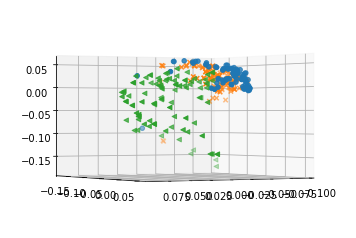

In [88]:
mds3 = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos3d= mds3.fit(matrix_bottleneck_distance_All_alpha).embedding_


plt.subplots_adjust(bottom = 0.1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=60,elev = 0)
ax.scatter(
    pos3d[:100, 0], pos3d[:100, 1],pos3d[:100, 2], marker = 'o'
    )
ax.scatter(
    pos3d[100:200, 0], pos3d[100:200, 1],pos3d[100:200, 2], marker = 'x'
    )
ax.scatter(
    pos3d[200:300, 0], pos3d[200:300, 1],pos3d[200:300, 2], marker = '<'
    )
plt.show()

### Observations

__For the different type of filtration used above, wer can observe a clear separation between classes (A,B,C). This separability is important in the task of classifying the 3 peddestrians walk. 
In addition, we can clearly observe from these plots that the 1-persistent diagrams and the alpha-complex based diagrams yield to much clearer separation of classes than the 0-persitent diagrams. Therefore we could expect to build a more accurate classifier using the formers.__

> # <span style="color:blue">Question 4</span> : Computing persistence landscape


__This function should take as input a persistence
diagram dgm (in the Gudhi format), a dimension k, the endpoints xmin, xmax of an interval, the
number nb_nodes of nodes of a regular grid on the interval [xmin, xmax] and a number of landscapes
nb_ld, and output a nbld × nbnodes array storing the values of the first nb_ld landscapes of dgm on the
node of the grid. Check, on some simple examples that your code is correct.__

In [47]:
def computeLandscapes(dgm,x_min,x_max,nb_nodes,nb_lbd):
    ''' This function compute the approximate landscape of a persistent diagram. 
    Given a range [xmin,xmax] and a grid size '''
    
    output = np.zeros((nb_lbd,nb_nodes))
    step = (x_max - x_min) / nb_nodes
    for i in range(nb_nodes):
        x = x_min + i * step
        event_list = []
        for tup in dgm:
            b = tup[0]
            d = tup[1]
            if (b <= x) and (x<= d):
                if x >= (d+b)/2. :
                    event_list.append((d-x))
                else:
                    event_list.append((x-b))
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        for j in range(nb_lbd):
            if(j<len(event_list)):
                output[j,i]=event_list[j]
    return output

> Example

In [48]:
diagA_1_pair_test= [diagA_1[0][a][1] for a in range(len(diagA_1[0]))] 
computeLandscapes(diagA_1_pair_test,0,15,400,5)

array([[ 0.    ,  0.0375,  0.075 , ..., 14.8875, 14.925 , 14.9625],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ]])

> # <span style="color:blue">Question 5</span>: First 5 landscapes on a relevant interval with a few hundred of nodes 




### Set parameter for the landscape approximation computation

In [49]:
epsilon=0.2
x_min=min(min(min_b_A_0,min_b_B_0,min_b_C_0),min(min_b_A_1,min_b_B_1,min_b_C_1))-epsilon
x_max=max(max(max_d_A_0,max_d_B_0,max_d_C_0),max(max_d_A_1,max_d_B_1,max_d_C_1))+epsilon
nb_nodes=300
nb_lbd=5

> with 0-persitent diagram

In [50]:
diagA_0_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagA_0_pairs]
diagB_0_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagB_0_pairs]
diagC_0_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagC_0_pairs]

> with 1-persitent diagram

In [51]:
diagA_1_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagA_1_pairs]
diagB_1_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagB_1_pairs]
diagC_1_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagC_1_pairs]

diagA_1_outliers_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagA_1_outliers_pairs]
diagB_1_outliers_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagB_1_outliers_pairs]
diagC_1_outliers_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagC_1_outliers_pairs]


> with alpha complex diagram

In [52]:
diagA_alpha_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagA_alpha_pairs]
diagB_alpha_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagB_alpha_pairs]
diagC_alpha_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagC_alpha_pairs]

## Random Forest

In [95]:
"""
Created on Sun Dec 17 18:33:31 2017

@author: Fredreci Chazal - All rights reserved
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Classification with random forests 
#### Interesting compare with L0_list, L1_list and L_list
#### where L0_list, L1_list and L_list are list storing the $0$-dimensional 
#### landscapes, $1$-dimensional landscapes, and the concatenation of both 
#### respectively

In [97]:
def runRFandPlot(List):
    avg = 0
    for i in range(20):
        L_train, L_test, label_train, label_test = train_test_split(List, label, test_size=0.2)
        RF = RandomForestClassifier()
        RF.fit(L_train, label_train)
        print(np.mean(RF.predict(L_test) == label_test) )
        avg += np.mean(RF.predict(L_test) == label_test)
        #print(confusion_matrix(RF.predict(L_test), label_test))
    print ("avg pred: ",avg/20)

    plt.plot(RF.feature_importances_)

> ## with 0-persistent 

In [53]:
l0A=[el.flatten() for el in diagA_0_landscapes]
l0B=[el.flatten() for el in diagB_0_landscapes]
l0C=[el.flatten() for el in diagC_0_landscapes]
L0_list=l0A+l0B+l0C


0.8
0.85
0.85
0.8833333333333333
0.85
0.8833333333333333
0.8166666666666667
0.9166666666666666
0.9
0.85
0.8666666666666667
0.85
0.8166666666666667
0.9333333333333333
0.8833333333333333
0.9
0.8833333333333333
0.8666666666666667
0.85
0.8666666666666667
avg pred:  0.8658333333333335


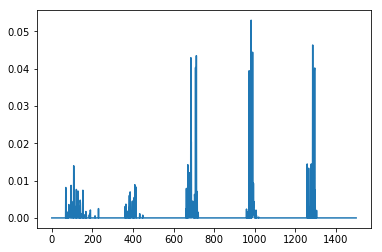

In [99]:
runRFandPlot(L0_list)

> ## with 1-persistent 

In [57]:
l1A=[el.flatten() for el in diagA_1_landscapes]
l1B=[el.flatten() for el in diagB_1_landscapes]
l1C=[el.flatten() for el in diagC_1_landscapes]
L1_list=l1A+l1B+l1C

0.95
0.9666666666666667
0.9833333333333333
0.9333333333333333
0.9333333333333333
0.9333333333333333
0.9666666666666667
0.9333333333333333
0.95
0.9166666666666666
0.9333333333333333
0.9166666666666666
0.9666666666666667
0.9333333333333333
0.9666666666666667
0.95
0.9166666666666666
0.9833333333333333
0.9166666666666666
0.8833333333333333
avg pred:  0.9416666666666668


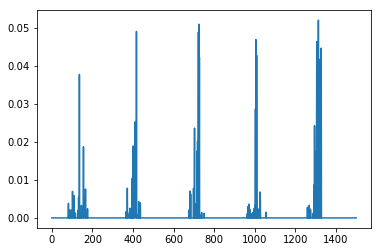

In [100]:
runRFandPlot(L1_list)

Attempt with outliers removed

l1A=[el.flatten() for el in diagA_1_outliers_landscapes]
l1B=[el.flatten() for el in diagB_1_outliers_landscapes]
l1C=[el.flatten() for el in diagC_1_outliers_landscapes]
L1_list_outliers=l1A+l1B+l1C

runRFandPlot(L1_list_outliers)

> ## With 0-persitent and 1-persitent concatenated

In [59]:
lA=[np.array(list(el.flatten()) +list(el2.flatten())) for el,el2 in zip(diagA_0_landscapes,diagA_1_landscapes)]
lB=[np.array(list(el.flatten()) +list(el2.flatten())) for el,el2 in zip(diagB_0_landscapes,diagB_1_landscapes)]
lC=[np.array(list(el.flatten()) +list(el2.flatten())) for el,el2 in zip(diagC_0_landscapes,diagC_1_landscapes)]
L_list=lA+lB+lC

0.9333333333333333
1.0
0.8333333333333334
0.95
0.95
0.9
0.95
0.9666666666666667
0.8833333333333333
1.0
0.95
0.9333333333333333
1.0
0.9666666666666667
0.8833333333333333
0.9333333333333333
0.9333333333333333
0.9333333333333333
0.9
0.95
avg pred:  0.9374999999999998


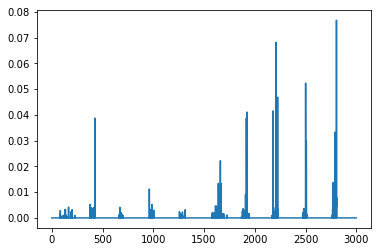

In [104]:
runRFandPlot(L_list)

## With alpha complex

In [63]:
lalphaA=[el.flatten() for el in diagA_alpha_landscapes]
lalphaB=[el.flatten() for el in diagB_alpha_landscapes]
lalphaC=[el.flatten() for el in diagC_alpha_landscapes]
Lalpha_list=lalphaA+lalphaB+lalphaC

0.95
0.95
0.8833333333333333
0.9833333333333333
0.9666666666666667
0.9833333333333333
0.9666666666666667
0.9833333333333333
0.9666666666666667
0.9666666666666667
0.9666666666666667
0.9666666666666667
0.9333333333333333
0.9833333333333333
0.9666666666666667
0.9666666666666667
0.9833333333333333
0.95
0.95
0.95
avg pred:  0.9608333333333332


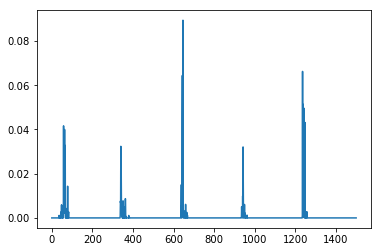

In [105]:
runRFandPlot(Lalpha_list)

> ## With Grid Search

In [61]:
# Define a scoring fonction to evaluate modelling
from sklearn.cross_validation import cross_val_score

def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

/Users/yaguethiam/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
### Use GridSearchCV to tune parameters for Random Forest
# turn run_gs to True if you want to run the gridsearch again.
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
train=L1_list
targets=label

run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8, None],
                 'n_estimators': [10, 20, 50, 100],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [1, 3, 10,30, 50],
                 'min_samples_leaf': [1, 3, 10, 30, 50],
                 'bootstrap': [True, False],
                 'criterion': ['gini', 'entropy']
                 }
    rf = RandomForestClassifier()
    cross_validation = StratifiedKFold(targets, n_folds=5)

    grid_search = GridSearchCV(rf,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)
    # Input the label of the training set and the related targets
    grid_search.fit(train, targets)
    rf_best = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    # **parameters enables to retrieve the optimal parameters derived from GridSearchCV
    rf_best = RandomForestClassifier(**parameters)
    
    # Again, input the correct names for the training set and its related target variables
    rf_best.fit(train, targets)
    
compute_score(rf_best, train, targets, scoring='accuracy')

/Users/yaguethiam/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.9400000000000001

> # <span style="color:blue">Question 6</span>: Classification using raw data



### __Do the same experiment as previously, but using the raw data ( 3 × 200 array of acceleration coordinates).__

In [65]:
l1A=[el.T.flatten() for el in data_A]
l1B=[el.T.flatten() for el in data_B]
l1C=[el.T.flatten() for el in data_C]
L1_list_row=l1A+l1B+l1C

0.8833333333333333
0.9333333333333333
0.8333333333333334
0.9
0.95
0.9333333333333333
0.9166666666666666
0.9
0.8333333333333334
0.8
0.9333333333333333
0.9333333333333333
0.8333333333333334
0.8666666666666667
0.8833333333333333
0.9
0.9666666666666667
0.9333333333333333
0.9166666666666666
0.8833333333333333
avg pred:  0.8966666666666668


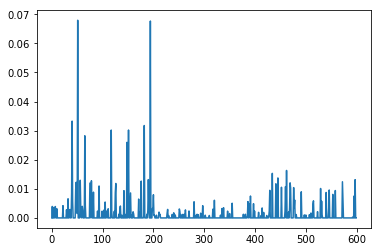

In [106]:
runRFandPlot(L1_list_row)

## Conclusion